# Setup and Imports

- Installing Hugging Face's nlp package
- Importing libraries

In [1]:
!pip install nlp

- Predefining a function for plotting validation and training graph. Also predefining a function for confusion matrix

## Import necessary libraries and defining a functions

- I am defining a show_history function here. I will use for plotting graph on history performance of our model.

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


# Importing Data

- Importing the Tweet Emotion dataset
- Creating train, validation and test sets
- Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to C:\Users\Anuj\.cache\huggingface\datasets\emotion\default\0.0.0\84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
test = dataset['test']
val = dataset['validation']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

# Tokenizer

- Tokenizing the tweets: Text to number

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [12]:
tweets[0]

'i didnt feel humiliated'

# Padding and Truncating Sequences

- Checking length of the tweets
- Creating padded sequences

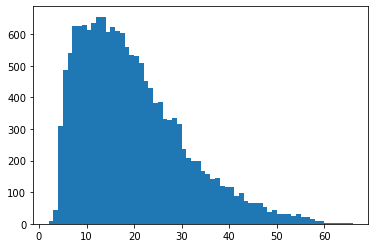

In [13]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [14]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [16]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [17]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

# Preparing the Labels

- Creating classes to index and index to classes dictionaries
- Converting text labels to numeric labels

In [18]:
classes = set(labels)
print(classes)

{'love', 'surprise', 'sadness', 'fear', 'joy', 'anger'}


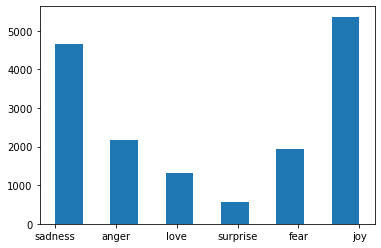

In [19]:
plt.hist(labels, bins=11)
plt.show()

In [20]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [21]:
class_to_index

{'love': 0, 'surprise': 1, 'sadness': 2, 'fear': 3, 'joy': 4, 'anger': 5}

In [22]:
index_to_class

{0: 'love', 1: 'surprise', 2: 'sadness', 3: 'fear', 4: 'joy', 5: 'anger'}

In [23]:
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [24]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


# Creating the Model

- Creating the model
- Compiling the model

In [25]:
model = tf.keras.models.Sequential([
         tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
         tf.keras.layers.Dense(6, activation='softmax')                    
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


# Task 7: Training the Model

- Preparing a validation set
- Training the model

In [27]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [28]:
val_tweets[0], val_labels[0], val_seq[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 2,
 array([ 17,   8, 157, 260,   4, 343,  16,  51,  19, 212,   1,  50,  10,
         13, 533,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]))

In [29]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 25s 37ms/step - loss: 1.3502 - accuracy: 0.4386 - val_loss: 0.8664 - val_accuracy: 0.6905
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.6120 - accuracy: 0.7801 - val_loss: 0.6137 - val_accuracy: 0.7915
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3766 - accuracy: 0.8742 - val_loss: 0.5008 - val_accuracy: 0.8425
Epoch 4/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2649 - accuracy: 0.9144 - val_loss: 0.4508 - val_accuracy: 0.8670
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.1907 - accuracy: 0.9421 - val_loss: 0.4321 - val_accuracy: 0.8655
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.1480 - accuracy: 0.9525 - val_loss: 0.4593 - val_accuracy: 0.8665


# Evaluating the Model

- Visualizing training history
- Prepraring a test set
- A look at individual predictions on the test set
- A look at all predictions on the test set

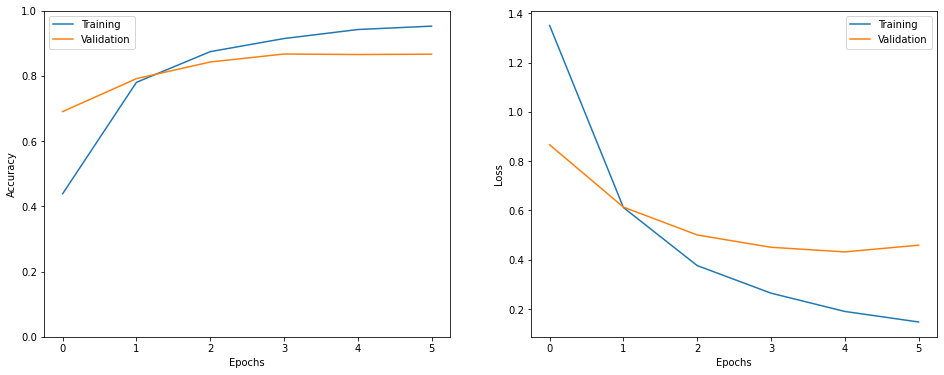

In [30]:
show_history(h)

**Working on Test data**

In [31]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [32]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 12ms/step - loss: 0.4178 - accuracy: 0.8750


In [33]:
i = random.randint(0, len(test_labels)-1)

print("Sentence: ", test_tweets[i])
print("Emotion: ", index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print("Predicted Emotion: ", pred_class)

Sentence:  i feel like i cant be respected if i have self respect because it is so regular to now hate your self
Emotion:  joy
Predicted Emotion:  joy


In [34]:
preds = np.argmax(model.predict(test_seq), axis=-1)

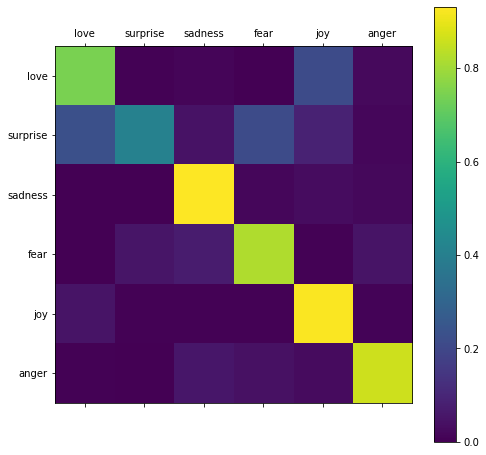

In [35]:
show_confusion_matrix(test_labels, preds, list(classes))

**Prediction on any sentences**

In [58]:
sentence = ["I am feeling very good"]
sentence_seq = get_sequences(tokenizer, sentence)

p = model.predict(np.expand_dims(sentence_seq[0], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print("Predicted Emotion: ", pred_class)

Predicted Emotion:  joy


That's it. We have build a model for recognizing tweet emotion.

**Thank You**